In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


## Önemli Nümerik Değişkenlerin İncelenmesi

In [3]:
# Nümerik değişkenlerin seçilmesi
num_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]
# Id & SalePrice değişkenlerinin çıkarılması
num_cols.remove('Id')
num_cols.remove('SalePrice')
# Num_cols u dataframe e çevirme
num_analysis = train[num_cols].copy()
# Eksik gözlemlerin doldurulması
for col in num_cols:
    if num_analysis[col].isnull().sum() > 0:
        num_analysis[col] = SimpleImputer(strategy='median').fit_transform(num_analysis[col].values.reshape(-1,1))
        
# Model
# ExtraTressRegressor 
clf = ExtraTreesRegressor(random_state=42)
etreg_model = clf.fit(num_analysis, train.SalePrice)


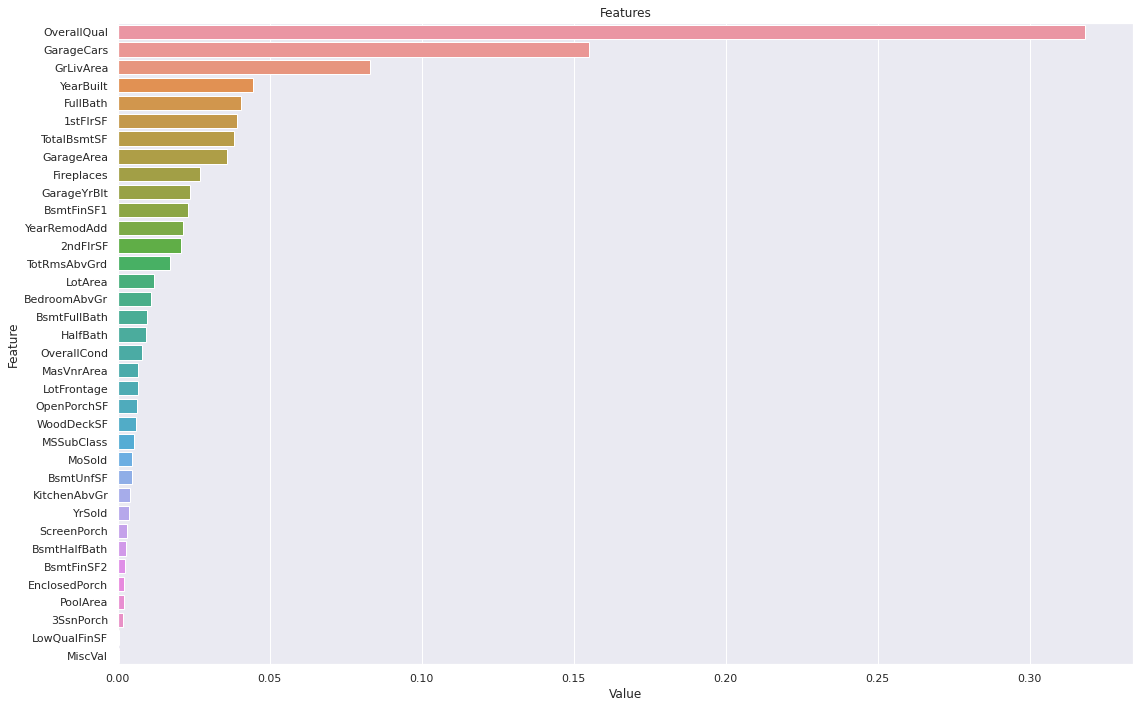

In [4]:
def plot_importance(model, features, num=len(num_cols), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features})
    plt.figure(figsize=(16, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(etreg_model, num_cols)


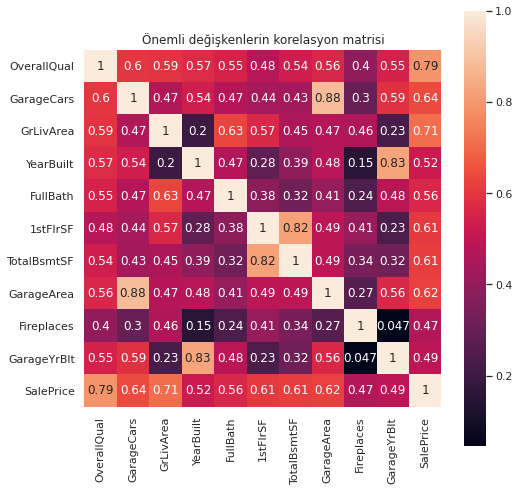

In [5]:
plt.figure(figsize=(8,8))
plt.title('Önemli değişkenlerin korelasyon matrisi')
cols =['OverallQual', 'GarageCars', 'GrLivArea', 'YearBuilt', 
       'FullBath', '1stFlrSF', 'TotalBsmtSF', 'GarageArea','Fireplaces','GarageYrBlt','SalePrice']
sns.heatmap(train[cols].corr(),annot=True,square=True);


* GarageCars ile GarageArea arasında 0.88 lik pozitif yönlü korelasyon var yani ilişkileri yüksek.
* YearBuilt ile GarageYrBlt arasında 0.83 lük korelasyon var.
* 1stFlrSF ile TotalBsmtSF arasında 0.82 lik koralsyon var.

In [6]:
# https://www.kaggle.com/mviola/house-prices-eda-lasso-lightgbm-0-11635 
def plot_numerical(col, discrete=False):
    if discrete:
        fig, ax = plt.subplots(1,2,figsize=(12,6))
        sns.stripplot(x=col, y='SalePrice', data=train, ax=ax[0])
        sns.countplot(train[col], ax=ax[1])
        fig.suptitle(str(col) + ' analysis')
    else:
        fig, ax = plt.subplots(1,2,figsize=(12,6))
        sns.scatterplot(x=col, y='SalePrice', data=train, ax=ax[0])
        sns.distplot(train[col], kde=False, ax=ax[1])
        fig.suptitle(str(col) + ' analysis')


print('Plot functions are ready to use')

Plot functions are ready to use


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


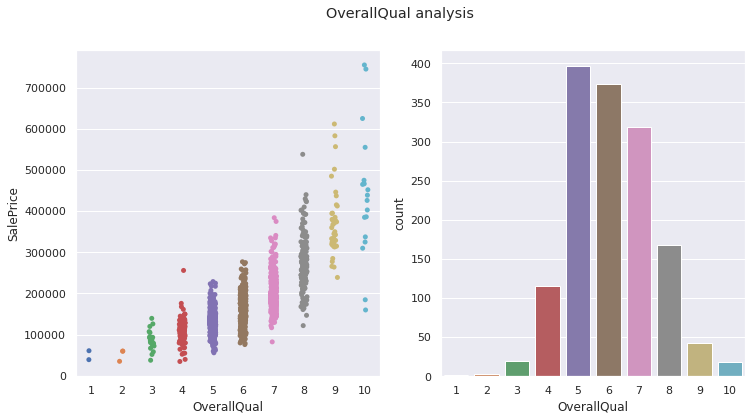

In [7]:
# cols =['OverallQual', 'GarageCars', 'GrLivArea', 'YearBuilt', 
       #'FullBath', '1stFlrSF', 'TotalBsmtSF', 'GarageArea','Fireplaces','GarageYrBlt','SalePrice']
plot_numerical('OverallQual',discrete=True)

* Genel malzeme kalitesi yüksek olanların fiyatları daha yüksek.
* Ama 10. kalitede olup fiyatı düşük olan iki gözlem var bunlar aykırı olabilir.
* 5.ve 6. kalitede olan evlerin sayısı daha fazla.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


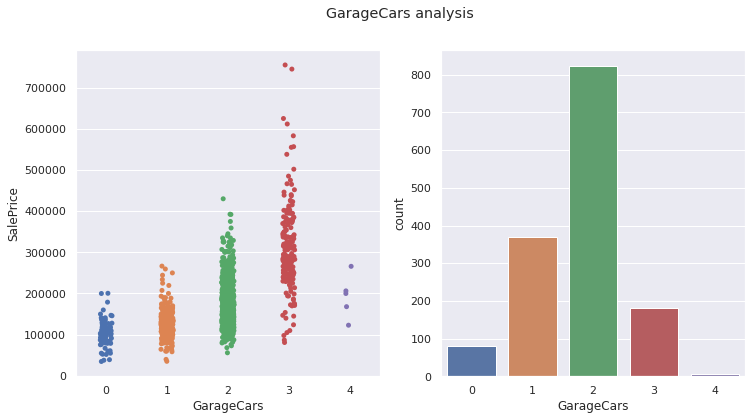

In [8]:
plot_numerical('GarageCars',discrete=True);

* Araç kapasitesi fazla olanların ev fiyatlarının yüksek olmasını bekleriz.
* Ama 3 araç kapasiteli garajı olan evlerin fiyatları 4 araç kapasiteli olanlardan daha fazla olması dikkat çekiyor.
* 4 araç kapasiteli garajı olan evlerin fiyatı daha düşük görünüyor.
* 2 araç kapasiteli garajı olan evlerin sayısı daha fazla.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


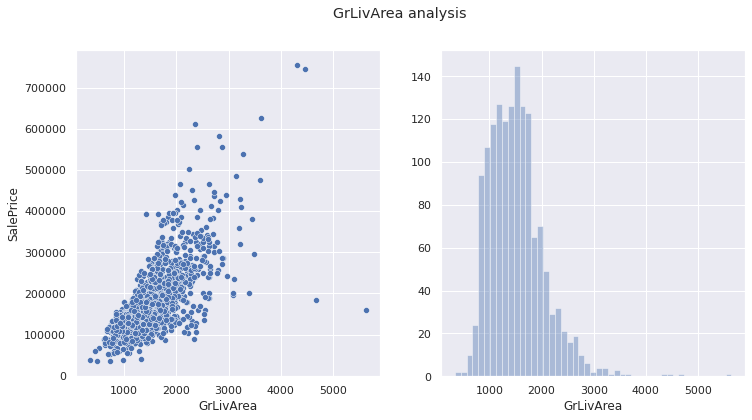

In [9]:
plot_numerical('GrLivArea');

* Metrekaresi yüksek olduğu halde(4000-5000) fiyatı düşük olan iki gözlem var,aykırı olabilir.
* GrLivArea ile SalePrice arasında doğrusal ilişki var gibi görünüyor.
* Evlerin oturma alanı genelde 1000 ile 2500 metrekare arasında yoğunluk göstermektedir.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


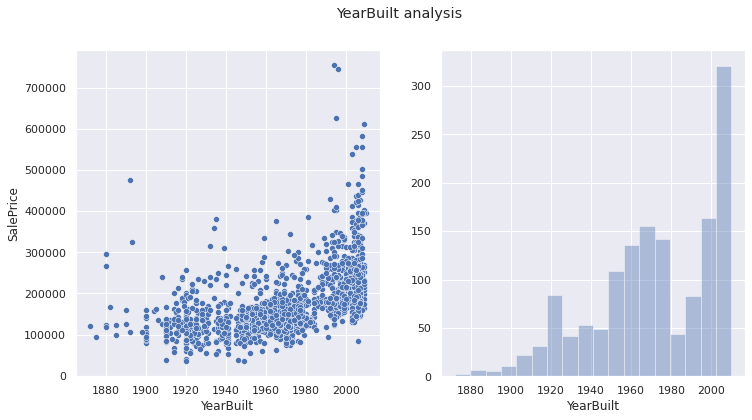

In [10]:
plot_numerical('YearBuilt');

* Yapım yılı 1880 ile 1900 arasında olup fiyatı yüksek olan evler var.Bunlar tarihi yapılar olabilir.
* 2000 yılı sonrasında yapılan evlerin fiyatları artmış.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


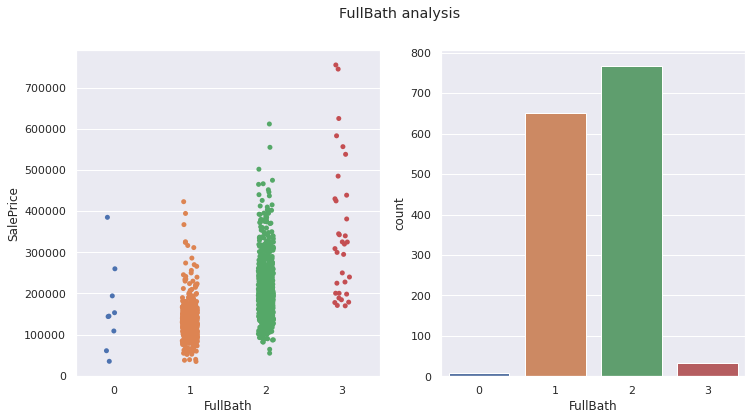

In [11]:
plot_numerical('FullBath',discrete=True);
# FullBath: Üst katlardaki tam banyolar

* Üst katta hiç banyosu olmadığı halde fiyatı yüksek olan evler var.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


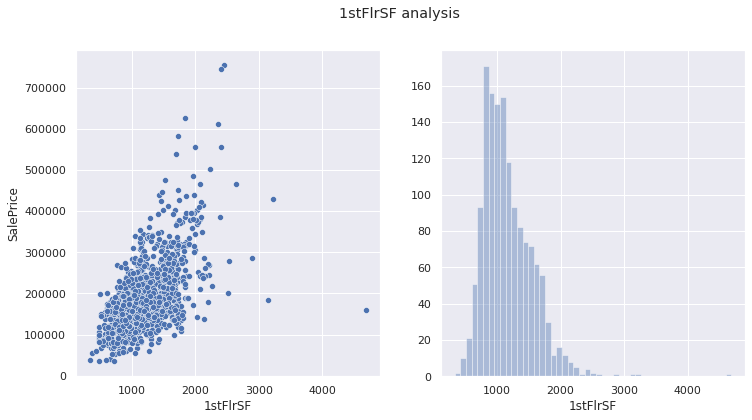

In [12]:
plot_numerical('1stFlrSF');
# 1stFlrSF : 1.kat metrekare alanı

* 1.kat metrekare alanı büyük olup fiyatı düşük olan evler var.Diğer değişkenlerle incelenmeli.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


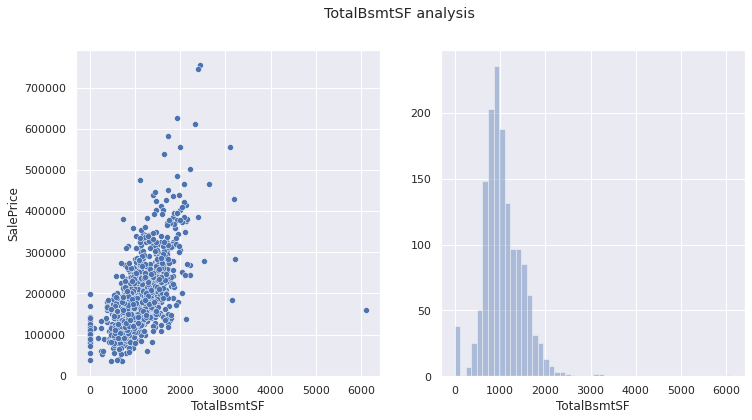

In [13]:
plot_numerical('TotalBsmtSF');
# TotalBsmtSF : Kare ayaklı duvar kaplama alanı

* TotalBsmtSF değişkeni toplam "Basement" yüzölçümünü veriyor."GrLivArea" ve "1stFlrSF" ve "2ndFlrSF" alan ölçümlerinin toplamı olduğu için bu değişkenlerin grafikleri ile benzer olduğu görülüyor.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


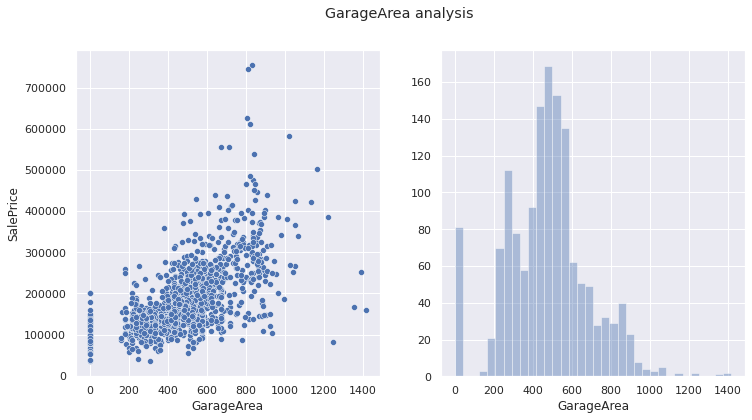

In [14]:
plot_numerical('GarageArea');

* Garaj alanı büyük olup fiyatı düşük olan evler var.
* Hiç garajı olmayan evler var.


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


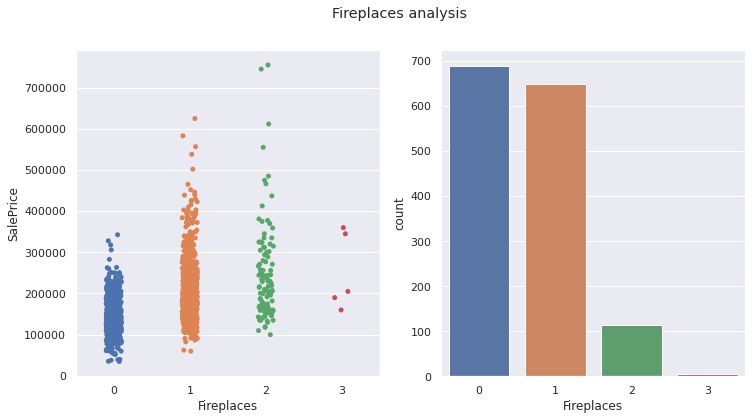

In [15]:
plot_numerical('Fireplaces',discrete=True);

* 3 şöminesi olup fiyatı daha düşük olan evler var.

## Önemli Kategorik Değişkenlerin İncelenmesi

In [16]:
# Kategorik değişkenlerin seçilmesi
cat_features = [col for col in train.columns if train[col].dtype =='object']

cat_analysis = train[cat_features].copy()

for col in cat_analysis:
    if cat_analysis[col].isnull().sum() > 0:
        cat_analysis[col] = SimpleImputer(strategy='constant').fit_transform(cat_analysis[col].values.reshape(-1,1))

# One-Hot Encoding
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
cat_analysis = one_hot_encoder(cat_analysis,cat_features)

# Model 
clf = ExtraTreesRegressor(random_state=42)
h = clf.fit(cat_analysis, train.SalePrice)


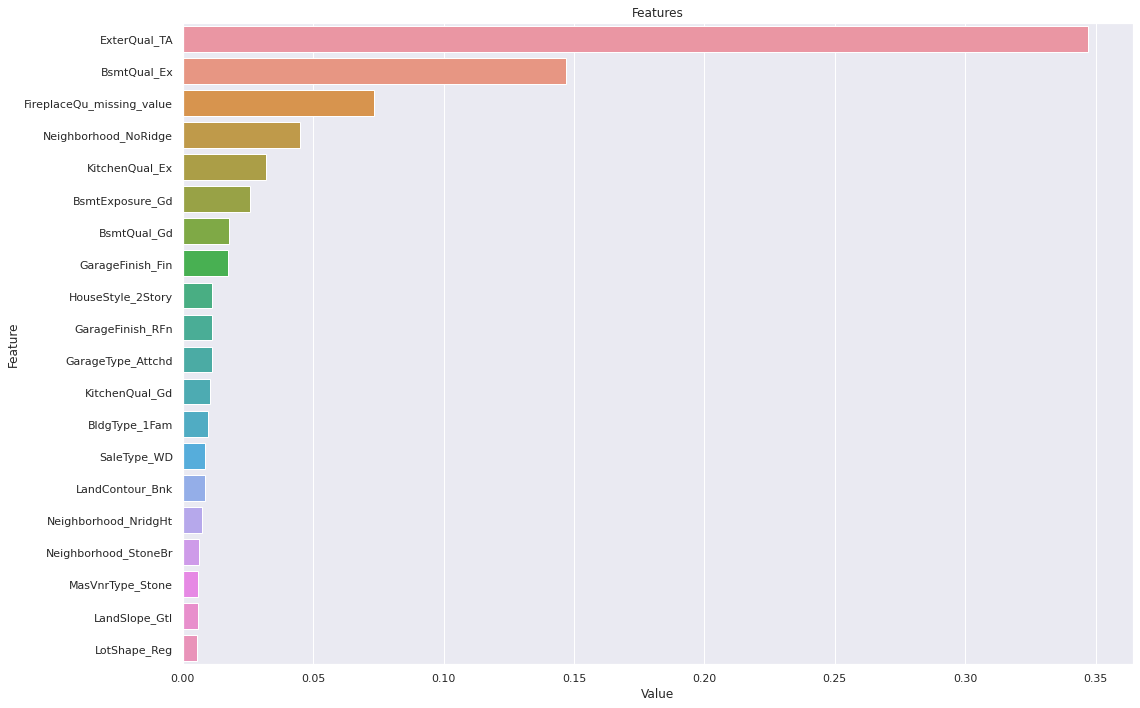

In [17]:
def plot_importance(model, features, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(16, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:20])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(h, cat_analysis)


In [18]:
cat_analysis["SalePrice"] = train["SalePrice"]


In [19]:
def cat_plot(col1,col2):
    # tüm veri
    fig, ax = plt.subplots(1,2,figsize=(12,6), sharey=True)
    sns.stripplot(x=col1, y='SalePrice', data=train, ax=ax[0])
    sns.boxplot(x=col1, y='SalePrice', data=train, ax=ax[1])
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
    fig.suptitle(str(col1) + ' analysis')
    
    # one-hot encoding
    fig, ax = plt.subplots(1,2,figsize=(12,6), sharey=True)
    sns.stripplot(x=col2, y='SalePrice', data=cat_analysis, ax=ax[0])
    sns.boxplot(x=col2, y='SalePrice', data=cat_analysis, ax=ax[1])
    fig.suptitle(str(col2) + ' analysis')



### ExterQual: Dış malzeme kalitesi
* Ex: Excellent
* Gd: Good
* TA: Average / Typical
* Fa: Fair
* Po: Poor

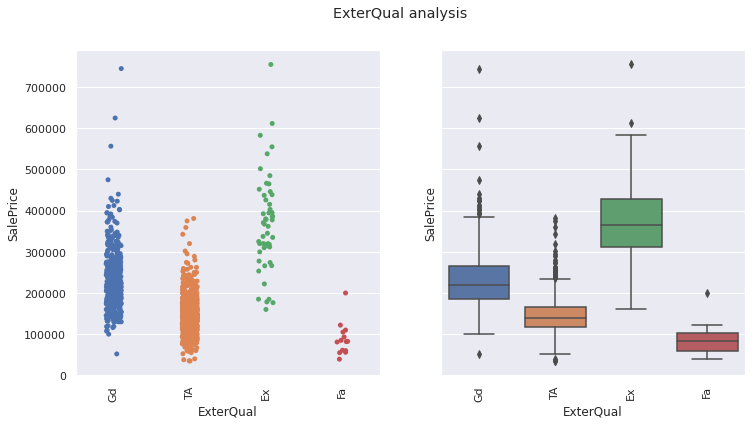

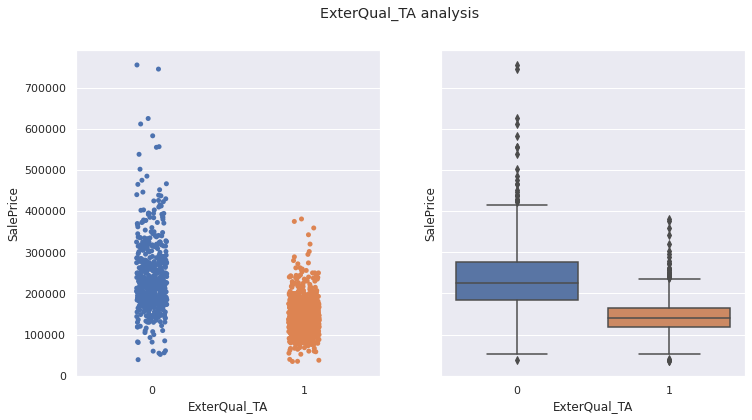

In [20]:
cat_plot("ExterQual","ExterQual_TA")

### BsmtQual: Bodrum yüksekliği
* Ex: Excellent (100+inches)
* Gd: Good (90-99)
* TA: Average / Typical (80-89)
* Fa: Fair (70-79)
* Po: Poor (<70)
* NA: No basement

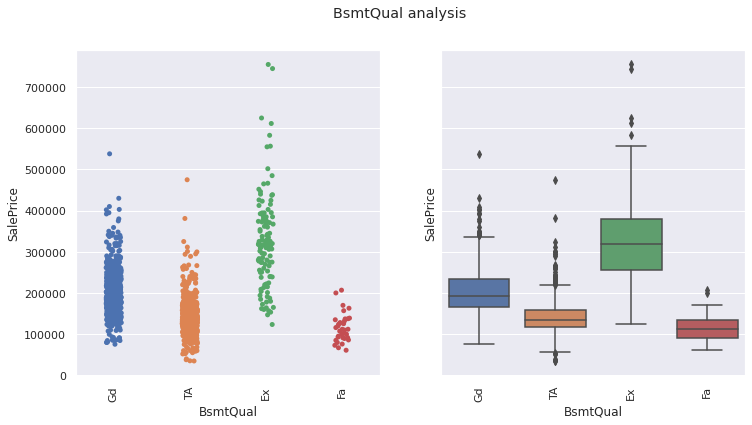

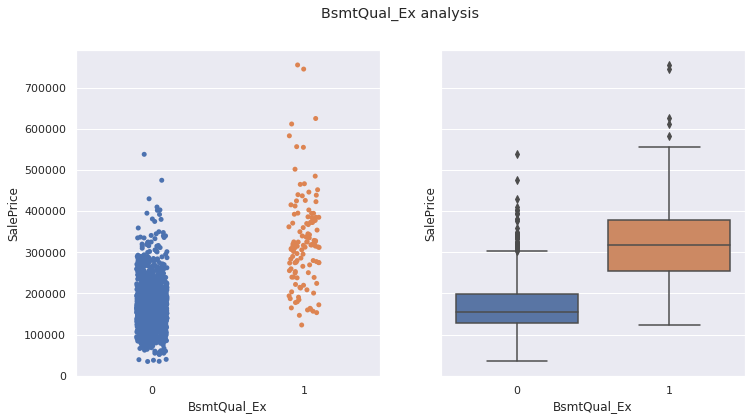

In [21]:
cat_plot("BsmtQual","BsmtQual_Ex")

### FirePlaceQu: Şömine kalitesi
* Ex: Excellent-Exceptional masonry fireplace(olağanüstü duvar şöminesi)
* Gd: Good - masonry fireplace in main level(ana seviyede)
* TA: Average / Typical- Prefabricated Fireplace in main living area or Masonry Fireplace in      basement(Prefabrik şömine ya da bodurm katında şömine)
* Fa: Fair- Prefabricated Fireplace in basement(bodrum prefabrik şömine)
* Po: Poor- Ben Franklin Stove
* NA: No fireplace

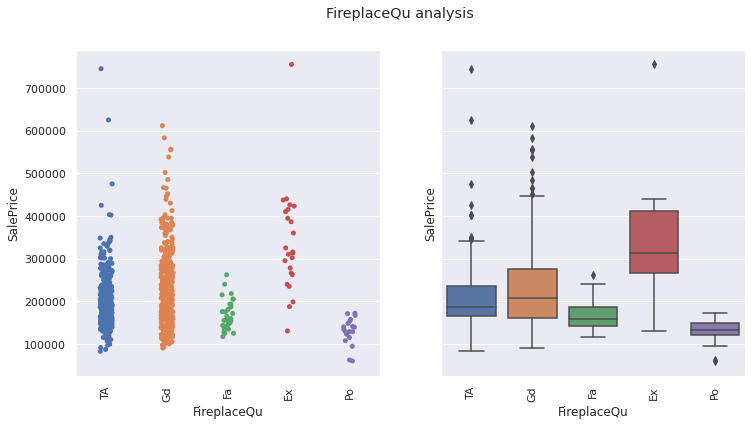

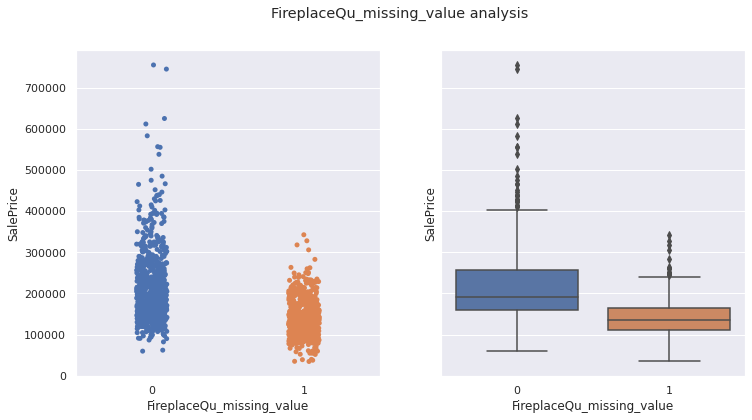

In [22]:
cat_plot("FireplaceQu","FireplaceQu_missing_value")

### Neighborhood: Ames şehir sınırları içindeki fiziksel konumları
* Neighborhood_NoRidge: Northridge

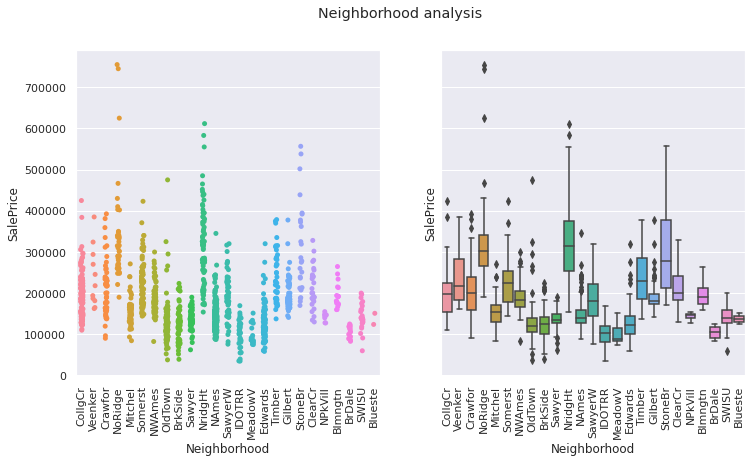

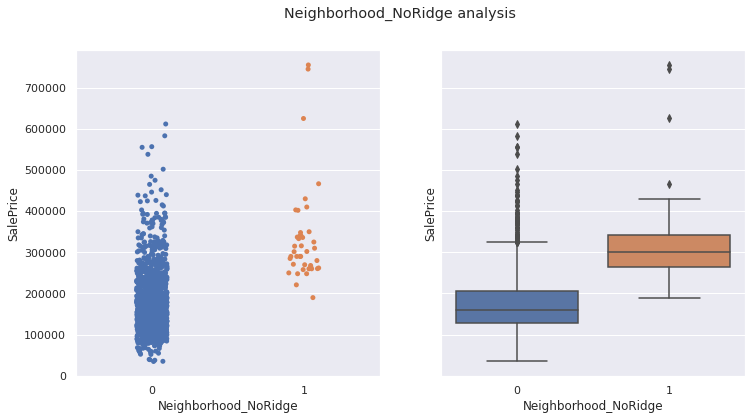

In [23]:
cat_plot("Neighborhood","Neighborhood_NoRidge")

* Diğer şehirlere bakıldığında en yüksek fiyatlı evler North Ridge de görünüyor bu nedenle SalePrice için belirleyici.Burada aykırılık olabilir.Aykırılıktan etkilenmiş olabilir.
### North Ridge de fiyatların yüksek olmasının sebebi California State Üniversitesinin bu ilçede olması olabilir,yani belki de aykırılık değildir.

## DATA PREPROCESSING & FEATURE ENGINEERING

### Missing Values

In [24]:
# train.drop('Id', axis=1, inplace=True)
# test.drop('Id', axis=1, inplace=True)

In [25]:
# Train ve test datalerını birleştirme
df = pd.concat([train, test]).reset_index(drop=True)
print(df.shape)

(2919, 81)


In [26]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns
    
missing_values_table(df)

              n_miss  ratio
PoolQC          2909  99.66
MiscFeature     2814  96.40
Alley           2721  93.22
Fence           2348  80.44
SalePrice       1459  49.98
FireplaceQu     1420  48.65
LotFrontage      486  16.65
GarageCond       159   5.45
GarageYrBlt      159   5.45
GarageFinish     159   5.45
GarageQual       159   5.45
GarageType       157   5.38
BsmtExposure      82   2.81
BsmtCond          82   2.81
BsmtQual          81   2.77
BsmtFinType2      80   2.74
BsmtFinType1      79   2.71
MasVnrType        24   0.82
MasVnrArea        23   0.79
MSZoning           4   0.14
Functional         2   0.07
BsmtHalfBath       2   0.07
BsmtFullBath       2   0.07
Utilities          2   0.07
KitchenQual        1   0.03
TotalBsmtSF        1   0.03
BsmtUnfSF          1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
BsmtFinSF2         1   0.03
BsmtFinSF1         1   0.03
Exterior2nd        1   0.03
Exterior1st        1   0.03
SaleType           1   0.03
Electrical         1

In [27]:
# Bazı değişkenledeki NAN olanları eksiklik olarak görüyor ama aslında bunlar
# eksiklik değil yokluğu ifade ediyor.Bu nedenle onları None olarak değiştireceğim.

none_cols = ['Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
             'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
             'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']


# Sayısal değerlerdeki Nan olanlar aslında yokluk anlamında olduğu için onları da 0 
# ile değiştireceğim.

zero_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
             'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea']

# Diğer değişkenlerde eksiklik az olduğu için mod ile dolduracağım.
freq_cols = ['Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual',
             'SaleType', 'Utilities']


for col in zero_cols:
    df[col].replace(np.nan, 0, inplace=True)

for col in none_cols:
    df[col].replace(np.nan, 'None', inplace=True)
    
for col in freq_cols:
    df[col].replace(np.nan, df[col].mode()[0], inplace=True)

In [28]:
missing_values_table(df)

             n_miss  ratio
SalePrice      1459  49.98
LotFrontage     486  16.65
MSZoning          4   0.14


In [29]:
# MsZoning(genel imar sınıflandırması) değişkenindeki boş değerleri 
# MSSubClassa(inşaat sınıfı) göre dolduracağım.

df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].apply(
    lambda x: x.fillna(x.mode()[0]))

# LotFrontage mülkiyetin cadde ile bağlantısını gösteren bir değişken, her mahallenin 
# cadde bağlantısının birbirine benzeyebileceğinden bunu Neighborhood'a göre dolduracağım.

df['LotFrontage'] = df.groupby(
    ['Neighborhood'])['LotFrontage'].apply(lambda x: x.fillna(x.median()))

missing_values_table(df)


           n_miss  ratio
SalePrice    1459  49.98


In [30]:
# Sayısal değişken olup aslında kategorik değişken olması gerekenleri düzeltme

df['MSSubClass'] = df['MSSubClass'].astype(str)
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   object 
 2   MSZoning       2919 non-null   object 
 3   LotFrontage    2919 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          2919 non-null   object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2919 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

## Feature Engineering

#### - LotShape(İmar şekli)

In [31]:
df["LotShape"].value_counts()

Reg    1859
IR1     968
IR2      76
IR3      16
Name: LotShape, dtype: int64

In [32]:
# LotShape(İmar şekli) değişkeninin IR2 ve IR3 alt sınıflarının frekansı düşük.
# Bu nedenle bunları IR1 e atayacağım.

df.loc[(df["LotShape"] == "IR2"), "LotShape"] = "IR1"
df.loc[(df["LotShape"] == "IR3"), "LotShape"] = "IR1"
df["LotShape"].value_counts()

Reg    1859
IR1    1060
Name: LotShape, dtype: int64

#### - ExterQual(Dış malzeme kalitesi)

In [33]:
df["ExterQual"].value_counts()

TA    1798
Gd     979
Ex     107
Fa      35
Name: ExterQual, dtype: int64

In [34]:
# Sınıflar arasında dengesizlik olduğu için Ex ve Gd(en iyi kaliteli iki sınıf) birleştirdik.
# TA ve Fa (orta kaliteli sınıf) birleştirdik

df.loc[df["ExterQual"]=="Ex","ExterQual"]=2
df.loc[df["ExterQual"]=="Gd","ExterQual"]=2
df.loc[df["ExterQual"]=="TA","ExterQual"]=1
df.loc[df["ExterQual"]=="Fa","ExterQual"]=1
df["ExterQual"]= df["ExterQual"].astype("int")

df["ExterQual"].value_counts()

1    1833
2    1086
Name: ExterQual, dtype: int64

#### - BsmtQual(Bodrum Yüksekliği)

In [35]:
df["BsmtQual"].value_counts()

TA      1283
Gd      1209
Ex       258
Fa        88
None      81
Name: BsmtQual, dtype: int64

In [36]:
# Sınıflar arasında dengesizlik olduğu için Ex ve Gd(90 ile 100 inches arası) birleştirdik.
# TA ve Fa (70 ile 89 inches arası) birleştirdik.
# None da yokluk olduğu için dokunmadık.

df.loc[df["BsmtQual"]=="Ex","BsmtQual"]=2
df.loc[df["BsmtQual"]=="Gd","BsmtQual"]=2
df.loc[df["BsmtQual"]=="TA","BsmtQual"]=1
df.loc[df["BsmtQual"]=="Fa","BsmtQual"]=1
df.loc[df["BsmtQual"]=="None","BsmtQual"]=0
df["BsmtQual"]= df["BsmtQual"].astype("int")

df["BsmtQual"].value_counts()

2    1467
1    1371
0      81
Name: BsmtQual, dtype: int64

#### KitchenQual(Mutfak kalitesi)

In [37]:
df["KitchenQual"].value_counts()

TA    1493
Gd    1151
Ex     205
Fa      70
Name: KitchenQual, dtype: int64

In [38]:
df.loc[df["KitchenQual"]=="Ex","KitchenQual"]=2
df.loc[df["KitchenQual"]=="Gd","KitchenQual"]=2
df.loc[df["KitchenQual"]=="TA","KitchenQual"]=1
df.loc[df["KitchenQual"]=="Fa","KitchenQual"]=1
df["KitchenQual"]= df["KitchenQual"].astype("int")
df["KitchenQual"].value_counts()

1    1563
2    1356
Name: KitchenQual, dtype: int64

#### - Neighborhood (Ames şehir sınırları içindeki fiziksel konum)

In [39]:
df.groupby("Neighborhood").agg({"SalePrice":"mean"}).sort_values(by="SalePrice", ascending=False)

,SalePrice
Neighborhood,
NoRidge,335295.317073
NridgHt,316270.623377
StoneBr,310499.000000
Timber,242247.447368
Veenker,238772.727273
Somerst,225379.837209
ClearCr,212565.428571
Crawfor,210624.725490
CollgCr,197965.773333


In [40]:
# https://www.kaggle.com/oguzerdo/top-1-house-pricing-project-regression-models
# Target değişkeninin ortalamasına göre birbirine benzeyen ilçeleri birleştirdik.

neigh_map = {'MeadowV': 1,'IDOTRR': 1,'BrDale': 1,'BrkSide': 2,'OldTown': 2,'Edwards': 2,
             'Sawyer': 3,'Blueste': 3,'SWISU': 3,'NPkVill': 3,'NAmes': 3,'Mitchel': 4,
             'SawyerW': 5,'NWAmes': 5,'Gilbert': 5,'Blmngtn': 5,'CollgCr': 5,
             'ClearCr': 6,'Crawfor': 6,'Veenker': 7,'Somerst': 7,'Timber': 8,
             'StoneBr': 9,'NridgHt': 10,'NoRidge': 10}

df['Neighborhood'] = df['Neighborhood'].map(neigh_map).astype('int')

In [41]:
# Derecelendirme içeren değişkenleri ordinal yapıya getireceğim.

ext_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df['ExterCond'] = df['ExterCond'].map(ext_map).astype('int')

bsm_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

df['BsmtCond'] = df['BsmtCond'].map(bsm_map).astype('int')

bsmf_map = {'None': 0,'Unf': 1,'LwQ': 2,'Rec': 3,'BLQ': 4,'ALQ': 5,'GLQ': 6}
df['BsmtFinType1'] = df['BsmtFinType1'].map(bsmf_map).astype('int')
df['BsmtFinType2'] = df['BsmtFinType2'].map(bsmf_map).astype('int')

heat_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df['HeatingQC'] = df['HeatingQC'].map(heat_map).astype('int')

df['FireplaceQu'] = df['FireplaceQu'].map(bsm_map).astype('int')
df['GarageCond'] = df['GarageCond'].map(bsm_map).astype('int')
df['GarageQual'] = df['GarageQual'].map(bsm_map).astype('int')


In [42]:
def rare_analyser(dataframe, target, rare_perc):
    
    rare_cols = [col for col in dataframe.columns if len(dataframe[col].value_counts()) <= 20
                    and (dataframe[col].value_counts() / len(dataframe) < rare_perc).sum() > 1]
    
    for col in rare_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")
        
rare_analyser(df, "SalePrice", 0.01)

MSSubClass : 16
     COUNT     RATIO    TARGET_MEAN
120    182  0.062350  200779.080460
150      1  0.000343            NaN
160    128  0.043851  138647.380952
180     17  0.005824  102300.000000
190     61  0.020898  129613.333333
20    1079  0.369647  185224.811567
30     139  0.047619   95829.724638
40       6  0.002055  156125.000000
45      18  0.006166  108591.666667
50     287  0.098321  143302.972222
60     575  0.196985  239948.501672
70     128  0.043851  166772.416667
75      23  0.007879  192437.500000
80     118  0.040425  169736.551724
85      48  0.016444  147810.000000
90     109  0.037342  133541.076923


MSZoning : 5
         COUNT     RATIO    TARGET_MEAN
C (all)     25  0.008565   74528.000000
FV         139  0.047619  214014.061538
RH          26  0.008907  131558.375000
RL        2267  0.776636  191004.994787
RM         462  0.158273  126316.830275


Condition1 : 9
        COUNT     RATIO    TARGET_MEAN
Artery     92  0.031518  135091.666667
Feedr     164  0.05618

#### - GarageCars(Garajın araba kapasitesi)

In [43]:
df["GarageCars"].value_counts()

2.0    1594
1.0     776
3.0     374
0.0     158
4.0      16
5.0       1
Name: GarageCars, dtype: int64

#### - LotConfig(Parsel yapılandırma)

In [44]:
df["LotConfig"].value_counts()

Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64

In [45]:
df.loc[(df["LotConfig"]=="Inside"),"LotConfig"] = 1
df.loc[(df["LotConfig"]=="FR2"),"LotConfig"] = 1
df.loc[(df["LotConfig"]=="Corner"),"LotConfig"] = 1

df.loc[(df["LotConfig"]=="FR3"),"LotConfig"] = 2
df.loc[(df["LotConfig"]=="CulDSac"),"LotConfig"] = 2
df["LotConfig"].value_counts()


1    2729
2     190
Name: LotConfig, dtype: int64

### - LandSlope(Mülkün eğimi)

In [46]:
df["LandSlope"].value_counts()

Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64

In [47]:
df.loc[df["LandSlope"] == "Gtl", "LandSlope"] = 1
df.loc[df["LandSlope"] == "Sev", "LandSlope"] = 2
df.loc[df["LandSlope"] == "Mod", "LandSlope"] = 2
df["LandSlope"]= df["LandSlope"].astype("int")
df["LandSlope"].value_counts()

1    2778
2     141
Name: LandSlope, dtype: int64

#### - OverallQual(Genel malzeme ve bitiş kalitesi) 

In [48]:
df["OverallQual"].value_counts()

5     825
6     731
7     600
8     342
4     226
9     107
3      40
10     31
2      13
1       4
Name: OverallQual, dtype: int64

In [49]:
df.loc[df["OverallQual"] == 1, "OverallQual"] = 1
df.loc[df["OverallQual"] == 2, "OverallQual"] = 1
df.loc[df["OverallQual"] == 3, "OverallQual"] = 1
df.loc[df["OverallQual"] == 4, "OverallQual"] = 2
df.loc[df["OverallQual"] == 5, "OverallQual"] = 3
df.loc[df["OverallQual"] == 6, "OverallQual"] = 4
df.loc[df["OverallQual"] == 7, "OverallQual"] = 5
df.loc[df["OverallQual"] == 8, "OverallQual"] = 6
df.loc[df["OverallQual"] == 9, "OverallQual"] = 7
df.loc[df["OverallQual"] == 10, "OverallQual"] = 8
df["OverallQual"].value_counts()

3    825
4    731
5    600
6    342
2    226
7    107
1     57
8     31
Name: OverallQual, dtype: int64

### - MasVnrType (Duvar kaplama türü)

In [50]:
df["MasVnrType"].value_counts()

None       1766
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64

In [51]:
df.loc[df["MasVnrType"] == "BrkCmn" , "MasVnrType"] = "None" 
df["MasVnrType"].value_counts()

None       1791
BrkFace     879
Stone       249
Name: MasVnrType, dtype: int64

### - Foundation (Vakıf tipi)

In [52]:
df["Foundation"].value_counts()

PConc     1308
CBlock    1235
BrkTil     311
Slab        49
Stone       11
Wood         5
Name: Foundation, dtype: int64

In [53]:
df.loc[df["Foundation"] == "Stone", "Foundation"] = "BrkTil"
df.loc[df["Foundation"] == "Wood", "Foundation"] = "CBlock"
df["Foundation"].value_counts()

PConc     1308
CBlock    1240
BrkTil     322
Slab        49
Name: Foundation, dtype: int64

### - Fence (Çit kalitesi)

In [54]:
df["Fence"].value_counts()

None     2348
MnPrv     329
GdPrv     118
GdWo      112
MnWw       12
Name: Fence, dtype: int64

In [55]:
df.loc[df["Fence"] == "MnWw", "Fence"] = "MnPrv"
df.loc[df["Fence"] == "GdWo", "Fence"] = "MnPrv"
df["Fence"].value_counts()

None     2348
MnPrv     453
GdPrv     118
Name: Fence, dtype: int64

## NEW FEATURES(YENİ DEĞİŞKENLER)

In [56]:
# Total banyo sayısı
df["TotalBath_NEW"] = df['BsmtFullBath'] + df['BsmtHalfBath'] * 0.5 + df['FullBath'] + df['HalfBath'] * 0.5

# Toplam Kat Sayısı
df['TotalSF_NEW'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF'])

# Toplam Veranda Alanı
df['TotalPorchSF_NEW'] = (df['OpenPorchSF'] + df['3SsnPorch'] +df['EnclosedPorch'] +df['ScreenPorch'] + df['WoodDeckSF'])

# Kaliteleriyle ilgili değişkenler
df["OVER_QUAL_NEW"] = df['OverallQual'] + df['OverallCond']

# Bodrum kalitesi
df["BSMT_QUAL_NEW"] = df['BsmtQual'] + df['BsmtCond']

# Dış malzeme kalitesi
df["EX_QUAL_NEW"] = df['ExterQual'] + df['ExterCond']

# Garaj kalitesi
df['TotalGrgQual_NEW'] = (df['GarageQual'] + df['GarageCond'])

# Genel kalite
df['TotalQual_NEW'] = df['OverallQual'] + df['EX_QUAL_NEW']  + df['TotalGrgQual_NEW'] + df['KitchenQual'] + df['HeatingQC']

# Lux evler
df.loc[(df['Fireplaces'] > 0) & (df['GarageCars'] >= 3), "LUX_NEW"] = 1
df["LUX_NEW"].fillna(0, inplace=True)
df["LUX_NEW"] = df["LUX_NEW"].astype(int)

# Restore Edilmemiş-Edilmemiş
df.loc[df["YearBuilt"] == df["YearRemodAdd"], "NEW_home"] = 0
df.loc[df["YearBuilt"] != df["YearRemodAdd"], "NEW_home"] = 1

df['QualPorch_NEW'] = df['EX_QUAL_NEW'] * df['TotalPorchSF_NEW']

df['HasPool_NEW'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['Has2ndFloor_NEW'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df['HasGarage_NEW'] = df['TotalGrgQual_NEW'].apply(lambda x: 1 if x > 0 else 0)
df['HasFireplace_NEW'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
df['HasPorch_NEW'] = df['QualPorch_NEW'].apply(lambda x: 1 if x > 0 else 0)

# Bahçe alanı
df["Garden_NEW"]=df["LotArea"] - df["GrLivArea"]

## OUTLIERS(Aykırı değerler)

In [57]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


In [58]:
num_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
for col in num_cols:
    replace_with_thresholds(df, col)

In [59]:
for col in num_cols:
    print(col, check_outlier(df, col))

Id False
LotFrontage False
LotArea False
LandSlope False
Neighborhood False
OverallQual False
OverallCond False
YearBuilt False
YearRemodAdd False
MasVnrArea False
ExterQual False
ExterCond False
BsmtQual False
BsmtCond False
BsmtFinType1 False
BsmtFinSF1 False
BsmtFinType2 False
BsmtFinSF2 False
BsmtUnfSF False
TotalBsmtSF False
HeatingQC False
1stFlrSF False
2ndFlrSF False
LowQualFinSF False
GrLivArea False
BsmtFullBath False
BsmtHalfBath False
FullBath False
HalfBath False
BedroomAbvGr False
KitchenAbvGr False
KitchenQual False
TotRmsAbvGrd False
Fireplaces False
FireplaceQu False
GarageYrBlt False
GarageCars False
GarageArea False
GarageQual False
GarageCond False
WoodDeckSF False
OpenPorchSF False
EnclosedPorch False
3SsnPorch False
ScreenPorch False
PoolArea False
MiscVal False
SalePrice False
TotalBath_NEW False
TotalSF_NEW False
TotalPorchSF_NEW False
OVER_QUAL_NEW False
BSMT_QUAL_NEW False
EX_QUAL_NEW False
TotalGrgQual_NEW False
TotalQual_NEW False
LUX_NEW False
NEW_home Fals

## RARE ENCODING

In [60]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 2919
Variables: 98
cat_cols: 76
num_cols: 22
cat_but_car: 0
num_but_cat: 43


In [61]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

def rare_encoder(dataframe, rare_perc,cat_cols):
    
    rare_columns = [col for col in cat_cols if (dataframe[col].value_counts()/len(dataframe) < 0.01).sum() > 1]

    for col in rare_columns:
        tmp = dataframe[col].value_counts() / len(dataframe)
        rare_labels = tmp[tmp < rare_perc].index
        dataframe[col] = np.where(dataframe[col].isin(rare_labels), 'Rare', dataframe[col])

    return dataframe

rare_analyser(df, "SalePrice", cat_cols)

MSSubClass : 16
     COUNT     RATIO    TARGET_MEAN
120    182  0.062350  199862.770115
150      1  0.000343            NaN
160    128  0.043851  138647.380952
180     17  0.005824  102300.000000
190     61  0.020898  129613.333333
20    1079  0.369647  181389.620336
30     139  0.047619   95829.724638
40       6  0.002055  156125.000000
45      18  0.006166  108591.666667
50     287  0.098321  142532.659722
60     575  0.196985  230464.811037
70     128  0.043851  166454.708333
75      23  0.007879  184002.343750
80     118  0.040425  169650.991379
85      48  0.016444  147810.000000
90     109  0.037342  133541.076923


MSZoning : 5
         COUNT     RATIO    TARGET_MEAN
C (all)     25  0.008565   74528.000000
FV         139  0.047619  213539.592308
RH          26  0.008907  131558.375000
RL        2267  0.776636  186641.265856
RM         462  0.158273  125457.082569


Street : 2
      COUNT     RATIO    TARGET_MEAN
Grvl     12  0.004111  130190.500000
Pave   2907  0.995889  177526.

In [62]:
df = rare_encoder(df, 0.01, cat_cols)

In [63]:
rare_analyser(df, "SalePrice", cat_cols)

MSSubClass : 12
      COUNT     RATIO    TARGET_MEAN
120     182  0.062350  199862.770115
160     128  0.043851  138647.380952
190      61  0.020898  129613.333333
20     1079  0.369647  181389.620336
30      139  0.047619   95829.724638
50      287  0.098321  142532.659722
60      575  0.196985  230464.811037
70      128  0.043851  166454.708333
80      118  0.040425  169650.991379
85       48  0.016444  147810.000000
90      109  0.037342  133541.076923
Rare     65  0.022268  140348.511905


MSZoning : 4
      COUNT     RATIO    TARGET_MEAN
FV      139  0.047619  213539.592308
RL     2267  0.776636  186641.265856
RM      462  0.158273  125457.082569
Rare     51  0.017472  109623.615385


Street : 2
      COUNT     RATIO    TARGET_MEAN
Grvl     12  0.004111  130190.500000
Pave   2907  0.995889  177526.056052


Alley : 3
      COUNT     RATIO    TARGET_MEAN
Grvl    120  0.041110  122219.080000
None   2721  0.932169  179623.849890
Pave     78  0.026721  168000.585366


LotShape : 2
    

In [64]:
useless_cols = [col for col in cat_cols if df[col].nunique() == 1 or
                (df[col].nunique() == 2 and (df[col].value_counts() / len(df) <= 0.02).any(axis=None))]
useless_cols

['Street',
 'Utilities',
 'Condition2',
 'RoofMatl',
 'Heating',
 'PoolQC',
 'LandSlope',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType2',
 'BsmtFinSF2',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'GarageQual',
 'GarageCond',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'TotalGrgQual_NEW',
 'LUX_NEW',
 'HasPool_NEW',
 'HasGarage_NEW',
 'HasPorch_NEW']

In [65]:
cat_cols = [col for col in cat_cols if col not in useless_cols]
df.shape

(2919, 98)

In [66]:
for col in useless_cols:
    df.drop(col, axis=1, inplace=True)
df.shape    

(2919, 72)

In [67]:
rare_analyser(df, "SalePrice", cat_cols)

MSSubClass : 12
      COUNT     RATIO    TARGET_MEAN
120     182  0.062350  199862.770115
160     128  0.043851  138647.380952
190      61  0.020898  129613.333333
20     1079  0.369647  181389.620336
30      139  0.047619   95829.724638
50      287  0.098321  142532.659722
60      575  0.196985  230464.811037
70      128  0.043851  166454.708333
80      118  0.040425  169650.991379
85       48  0.016444  147810.000000
90      109  0.037342  133541.076923
Rare     65  0.022268  140348.511905


MSZoning : 4
      COUNT     RATIO    TARGET_MEAN
FV      139  0.047619  213539.592308
RL     2267  0.776636  186641.265856
RM      462  0.158273  125457.082569
Rare     51  0.017472  109623.615385


Alley : 3
      COUNT     RATIO    TARGET_MEAN
Grvl    120  0.041110  122219.080000
None   2721  0.932169  179623.849890
Pave     78  0.026721  168000.585366


LotShape : 2
     COUNT     RATIO    TARGET_MEAN
IR1   1060  0.363138  202291.134579
Reg   1859  0.636862  162895.428649


LandContour : 4
  

## One-Hot Encoder

In [68]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [69]:
df = one_hot_encoder(df, cat_cols, drop_first=True)
df.shape

(2919, 222)

In [70]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 2919
Variables: 222
cat_cols: 200
num_cols: 22
cat_but_car: 0
num_but_cat: 200


In [71]:
rare_analyser(df, "SalePrice", cat_cols)

MSSubClass_160 : 2
   COUNT     RATIO    TARGET_MEAN
0   2791  0.956149  179076.051181
1    128  0.043851  138647.380952


MSSubClass_190 : 2
   COUNT     RATIO    TARGET_MEAN
0   2858  0.979102  178332.607343
1     61  0.020898  129613.333333


MSSubClass_20 : 2
   COUNT     RATIO    TARGET_MEAN
0   1840  0.630353  174977.480519
1   1079  0.369647  181389.620336


MSSubClass_30 : 2
   COUNT     RATIO    TARGET_MEAN
0   2780  0.952381  181374.390726
1    139  0.047619   95829.724638


MSSubClass_50 : 2
   COUNT     RATIO    TARGET_MEAN
0   2632  0.901679  181139.305091
1    287  0.098321  142532.659722


MSSubClass_60 : 2
   COUNT     RATIO    TARGET_MEAN
0   2344  0.803015  163647.760551
1    575  0.196985  230464.811037


MSSubClass_70 : 2
   COUNT     RATIO    TARGET_MEAN
0   2791  0.956149  177797.675714
1    128  0.043851  166454.708333


MSSubClass_80 : 2
   COUNT     RATIO    TARGET_MEAN
0   2801  0.959575  177649.266049
1    118  0.040425  169650.991379


MSSubClass_85 : 2
   C

In [72]:
useless_cols_new = [col for col in cat_cols if (df[col].value_counts() / len(df) <= 0.01).any(axis=None)]
useless_cols_new

['Exterior1st_Rare',
 'Electrical_Rare',
 'MiscFeature_Rare',
 'BsmtFullBath_2.5',
 'FullBath_Rare',
 'HalfBath_2.0',
 'TotRmsAbvGrd_Rare',
 'Fireplaces_2.5',
 'GarageCars_3.5',
 'OVER_QUAL_NEW_14.0',
 'EX_QUAL_NEW_Rare']

In [73]:
for col in useless_cols_new:
    df.drop(col, axis=1, inplace=True)
df.shape    

(2919, 211)

## MODEL

In [74]:
#test train setini önce birleştirmiştik şimdi ayıralım
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()].drop("SalePrice", axis=1)

In [75]:
y = np.log1p(train_df['SalePrice'])
X = train_df.drop(["Id", "SalePrice"], axis=1)

# Base Model

In [76]:
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]

In [77]:
for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 0.1262 (LR) 
RMSE: 0.1227 (Ridge) 
RMSE: 0.1667 (Lasso) 


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03644009771872447, tolerance: 0.017033256807310982
  positive)


RMSE: 0.1596 (ElasticNet) 
RMSE: 0.2097 (KNN) 
RMSE: 0.1987 (CART) 
RMSE: 0.1336 (RF) 
RMSE: 0.1928 (SVR) 
RMSE: 0.124 (GBM) 
RMSE: 0.1375 (XGBoost) 
RMSE: 0.1286 (LightGBM) 
RMSE: 0.1157 (CatBoost) 


* **Hyperparameter Optimization**

In [78]:
lgbm_model = LGBMRegressor(random_state=46)

In [79]:
# modelleme öncesi hata:
rmse = np.mean(np.sqrt(-cross_val_score(lgbm_model,
                                        X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

0.12675547963243222

In [80]:
lgbm_params = {"learning_rate": [0.001, 0.01, 0.05, 0.1],
               "n_estimators": [200, 500, 750],
               "max_depth": [-1, 2, 5, 8],
               "colsample_bytree": [1, 0.50, 0.75],
               "num_leaves": [25, 31, 44]}

In [81]:
lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=10,
                            n_jobs=-1,
                            verbose=True).fit(X, y)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 21.6min finished


In [82]:
lgbm_gs_best.best_params_

{'colsample_bytree': 0.75,
 'learning_rate': 0.05,
 'max_depth': 2,
 'n_estimators': 750,
 'num_leaves': 25}

In [83]:
final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X, y)

In [84]:
rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")))
rmse
#hiperparametrelerin default kendi değeriyle rmse 0.12676 idi.
#optimizasyonlarla 0.1228 e indirdik

0.12281029384862836

## Feature Selection

In [85]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

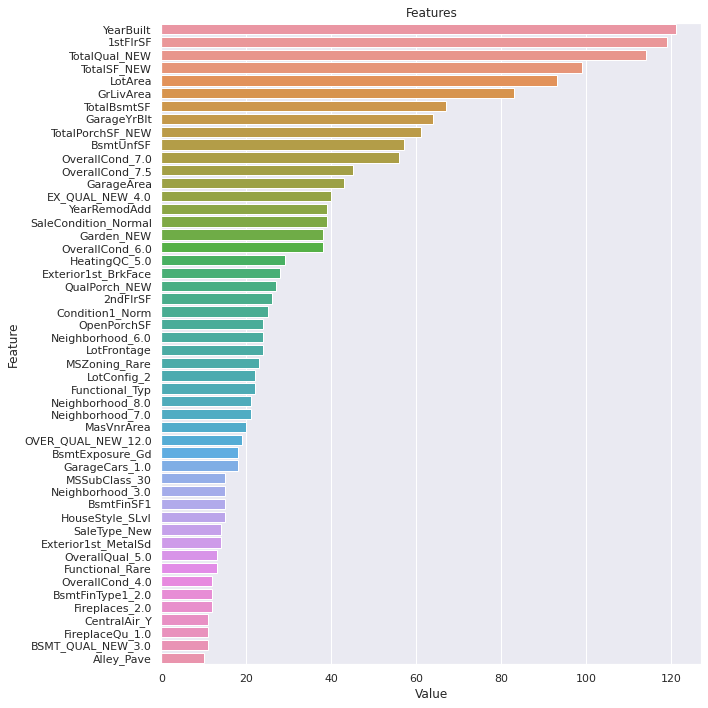

In [86]:
plot_importance(final_model, X, 50)

In [87]:
feature_imp = pd.DataFrame({'Value': final_model.feature_importances_, 'Feature': X.columns})
feature_imp.sort_values(by="Value",ascending=False)


,Value,Feature
2,121,YearBuilt
8,119,1stFlrSF
17,114,TotalQual_NEW
15,99,TotalSF_NEW
1,93,LotArea
...,...,...
100,0,PavedDrive_P
98,0,GarageFinish_RFn
97,0,GarageFinish_None
96,0,GarageType_Rare


In [88]:
feature_imp[feature_imp["Value"] > 0].shape

(132, 2)

In [89]:
feature_imp[feature_imp["Value"] < 1].shape

(77, 2)

In [90]:
zero_imp_cols = feature_imp[feature_imp["Value"] < 1]["Feature"].values
zero_imp_cols

array(['MSSubClass_160', 'MSSubClass_190', 'MSSubClass_20',
       'MSSubClass_50', 'MSSubClass_80', 'MSSubClass_85',
       'MSSubClass_Rare', 'MSZoning_RM', 'Alley_None', 'LandContour_Low',
       'Condition1_PosN', 'Condition1_Rare', 'BldgType_2fmCon',
       'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_SFoyer',
       'RoofStyle_Hip', 'Exterior1st_CemntBd', 'Exterior1st_Plywood',
       'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng',
       'Exterior1st_WdShing', 'Exterior2nd_BrkFace',
       'Exterior2nd_CmentBd', 'Exterior2nd_MetalSd', 'Exterior2nd_Rare',
       'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng',
       'Exterior2nd_Wd Shng', 'MasVnrType_None', 'Foundation_Slab',
       'BsmtExposure_Mn', 'BsmtExposure_None', 'Electrical_FuseF',
       'Functional_Min2', 'Functional_Mod', 'GarageType_Basment',
       'GarageType_BuiltIn', 'GarageType_Detchd', 'GarageType_None',
       'GarageType_Rare', 'GarageFinish_None', 'GarageFinish_RF

In [91]:
selected_cols = [col for col in X.columns if col not in zero_imp_cols]
len(selected_cols)

132

# Hyperparameter Optimization with Selected Features

In [92]:
lgbm_model = LGBMRegressor(random_state=46)

In [93]:
lgbm_params = {"learning_rate": [0.001, 0.01, 0.05, 0.1],
               "n_estimators": [200, 500, 750],
               "max_depth": [-1, 2, 5, 8],
               "colsample_bytree": [1, 0.50, 0.75],
               "num_leaves": [25, 31, 44]}

In [94]:
lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=10,
                            n_jobs=-1,
                            verbose=True).fit(X[selected_cols], y)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 20.4min finished


In [95]:
final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X[selected_cols], y)

In [96]:
rmse = np.mean(np.sqrt(-cross_val_score(final_model, X[selected_cols], y, cv=5, scoring="neg_mean_squared_error")))
rmse

#bir önceli rmse değeri 0.12281029384862836
#çöp değişkenlerle azaltmış olduk biraz da olsa 0.12315210453826239

0.12315210453826239

# Sonuçların Yüklenmesi

In [97]:
submission_df = pd.DataFrame()

In [98]:
submission_df['Id'] = test_df["Id"]

In [99]:
y_pred_sub = final_model.predict(test_df[selected_cols])

In [100]:
y_pred_sub = np.expm1(y_pred_sub) #ölçeklendirmiştik ya onu geri aldık

In [101]:
submission_df['SalePrice'] = y_pred_sub

In [102]:
submission_df["Id"]=submission_df["Id"].astype("int32")

In [103]:
submission_df.dtypes

Id             int32
SalePrice    float64
dtype: object

In [104]:
submission_df.to_csv('submission.csv', index=False)

In [105]:
submission_df

,Id,SalePrice
1460,1461,113457.223510
1461,1462,158860.086696
1462,1463,179949.015397
1463,1464,194689.675317
1464,1465,188214.146670
...,...,...
2914,2915,78874.617451
2915,2916,79688.492292
2916,2917,160367.803433
2917,2918,108773.767176
